In [ ]:
import pandas as pd
import html
#nltk.download() #only for the first time running it
# from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt

import json
import regex as re
from textblob import TextBlob
import numpy
import seaborn as sns

In [21]:
#create dataframe on USE FOR ALL DATA
def createDataFrame():  
    with open("C:/Users/Administrator/Desktop/tweets.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                yield (row['author_id'],
                        row['id'],
                        row['text'],
                        row['public_metrics']['retweet_count'],
                        row['public_metrics']['quote_count'],
                        row['public_metrics']['reply_count'],
                        row['public_metrics']['like_count'])
            except KeyError:
                pass

#create csv
output = pd.DataFrame(createDataFrame())
output.columns =['author_id', "id", 'text', 'retweet_count', 'quote_count', 'reply_count', 'like_count']
output['total'] = output[['retweet_count', 'quote_count','reply_count', 'like_count']].sum(axis=1)
#sort by highest total
output = output.sort_values(by = 'total', ascending = False)

In [ ]:
print(output['total'].max())

In [ ]:
#prep stop words
stop_words = stopwords.words('english')
stop_words.append('rt')
stop_words.append('nft')
# stop_words.append('#nft')

#function for cleaning a tweet (remove mentions, hashtags, links, html entities, stop words. And make sure it's only letters)
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        tweet = str.lower(tweet)
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
        tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9_]+)", " ", tweet).split()) # remove mentions and hashtags
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)", " ", tweet).split())
        tweet = re.sub("(http\S+|http)", "", tweet, flags=re.MULTILINE) # remove links
        tweet = re.sub('\&\w+', "", tweet) # remove html entities
        tweet = re.sub('[^a-zA-Z# ]+', ' ', tweet) # make sure tweet is only letters
        # stem & remove stop words
        # tweet = ' '.join([PorterStemmer().stem(word=word) for word in tweet.split() if word not in stop_words])
        tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
        return tweet

#clean data
for i in output.index:
    text = output["text"][i]
    cleaned_text = clean_tweet(text)
    cleaned_text = html.unescape(cleaned_text)
    output["text"][i] = cleaned_text

In [ ]:
positivity = ''
#Textblob
def getSentiment():
    counter = 0
    for i in output.index:
        row = TextBlob(output.iloc[i]['text'])
        counter = counter + 1
        print('line' , counter)
        if row.sentiment.polarity >= 0.7:
                positivity = 'mostly_positive'
        elif row.sentiment.polarity <= -0.7:
            positivity = 'mostly_negative'
        elif row.sentiment.polarity > -0.7 and row.sentiment.polarity < -0.4:
            positivity = 'negative'
        elif row.sentiment.polarity > 0.4 and row.sentiment.polarity < 0.7:
                positivity = 'positive'
        else:
            positivity = 'nuetral'
        yield  row.sentiment.polarity, row.sentiment.subjectivity, positivity
        
df = pd.DataFrame(getSentiment())
df.columns =['polarity', 'subjectivity', 'positivity']
output['polarity'] = df['polarity']
output['subjectivity'] = df['subjectivity']
output['positivity'] = df['positivity']

In [ ]:
#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

positivity = ''
#Textblob
def getSentiment():
    for i in output.index:
        row = analyzer.polarity_scores(output.iloc[i]['text'])
        yield  row['neg'], row['neu'], row['pos'], row['compound']
        
df = pd.DataFrame(getSentiment())
df.columns =['neg', 'neu', 'pos', 'compound']
output['Negativity'] = df['neg']
output['Neutral'] = df['neu']
output['Positivity'] = df['pos']
output['Compound'] = df['compound']

In [ ]:
output.to_json('graphs/tweets_vader_sentiment.jsonl', orient='records', index=True, lines= True)

In [ ]:
output2 = pd.read_json('C:/Users/Administrator/Desktop/tweets.jsonl', lines=True)

In [ ]:
output.to_json('graphs/tweets_replies_vader_sentiment.jsonl', orient='records', index=True, lines= True)

In [ ]:
output.to_json('graphs/tweets_original_vader_sentiment.jsonl', orient='records', index=True, lines= True)

In [ ]:
output = pd.read_json('graphs/tweets_vader_sentiment.jsonl', lines=True)

In [ ]:
output = pd.read_json('graphs/cleaned_tweets_textblob.jsonl', lines=True)

In [ ]:
# adds the title
plt.title('Correlation between Polarity and Subjectivity') 
  
# fits the best fitting line to the data
theta = numpy.polyfit(output['subjectivity'], output['polarity'], 1)
y_line = theta[1] + theta[0] * output['subjectivity']
plt.scatter(output['subjectivity'], output['polarity'])  
plt.plot(output['subjectivity'], y_line, 'r')
# Labelling axes
plt.xlabel('subjectivity')
plt.ylabel('polarity')


output["polarity"].corr(output["subjectivity"])

In [ ]:
output = pd.read_json('graphs/tweets_vader_sentiment.jsonl', lines=True)
output['total'] = numpy.log(output.total)
output = output.loc[output['total'] > 2]

# adds the title
plt.title('Correlation between Polarity and Total Interactions') 

# fits the best fitting line to the data
theta = numpy.polyfit(output['total'], output['Compound'], 1)
y_line = theta[1] + theta[0] * output['total']
plt.scatter(output['total'], output['Compound'])  
plt.plot(output['total'], y_line, 'r')
# Labelling axes
plt.xlabel('Total Interactions')
plt.ylabel('Compound')


output["Compound"].corr(output["total"])
plt.show()

In [ ]:
output = pd.read_json('graphs/cleaned_tweets_textblob.jsonl', lines=True)
output['total'] = numpy.log(output.total)
output = output.loc[output['total'] > 2]

# adds the title
plt.title('Correlation between Subjectivity and Total Interactions') 
  
# fits the best fitting line to the data
theta = numpy.polyfit(output['total'], output['subjectivity'], 1)
y_line = theta[1] + theta[0] * output['total']
plt.scatter(output['total'], output['subjectivity'])  
plt.plot(output['total'], y_line, 'r')
# Labelling axes
plt.xlabel('Total Interactions')
plt.ylabel('Subjectivity')



plt.show()
output["subjectivity"].corr(output["total"])

In [ ]:
import networkx as nx
import networkx.algorithms.community as nxcom
import karateclub 
import pandas as pd
import json
def createEdgeList():  
    with open("C:/Users/Administrator/Desktop/tweets.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                yield (row['author_id'],
                        row['in_reply_to_user_id'],
                        )
            except KeyError:
                pass

edge_list_df = pd.DataFrame(createEdgeList())
edge_list_df.columns =['Source', 'Target']
edge_list_df.to_json('graphs/edgelist.jsonl', orient='records', index=True, lines= True)


In [ ]:
import matplotlib.pyplot as plt
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)     
G = nx.from_pandas_edgelist(edge_list_df.head(1000), source='Source', target='Target')
pos=nx.spring_layout(G)
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

labels = nxcom.label_propagation(G, communities)

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
plt.style.use('dark_background')

# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

# Set community color for internal edges
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
# external edges
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=0, 
    edgelist=external, 
    edge_color="silver",
    node_color=node_color,
    alpha=0.2, 
    labels=labels)
# internal edges
nx.draw_networkx(
    G, pos=pos, 

    edgelist=internal, 
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.05, 
    labels=labels)
pos = nx.spring_layout(G, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=0, 
    edge_color="#444444", 
    alpha=0.05, 
    with_labels=False)
plt.show()

In [ ]:
output = output.loc[output['Positivity'] > 0]
output = output.loc[output['Negativity'] > 0]
output = output.loc[output['Neutral'] > 0]
output = output.loc[output['Compound'] > 0]

plt.figure(figsize=(12,4))
sns.distplot(output['Positivity'], bins=30, kde=False, 
                color='green', label='Positivity')
sns.distplot(output['Negativity'], bins=30, kde=False, 
            color='red', label='Negativity')      
sns.distplot(output['Neutral'], bins=30, kde=False, 
            color='grey', label='Neutral')
sns.distplot(output['Compound'], bins=30, kde=False, 
            color='pink', label='Compound')
plt.ylabel('Tweet Count')
plt.xlabel('Sentiment Score')
plt.legend()
plt.title(f'Histogram of Original Sentiment')

In [ ]:
#Top 1000 term frequency
output = output.sort_values(by = 'total', ascending = False)
output = output.head(10000)

from collections import Counter
results = Counter()
output['text'].str.lower().str.split().apply(results.update)
print(results, "\n")

In [ ]:
#prep stop words
stop_words = stopwords.words('english')
stop_words.append('rt')
stop_words.append('nft')
# stop_words.append('#nft')
counter = 0
#function for cleaning a tweet (remove mentions, hashtags, links, html entities, stop words. And make sure it's only letters)
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        tweet = str.lower(tweet)
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
        tweet = ' '.join(re.sub("(#nft+)", " ", tweet).split()) # remove mentions and hashtags
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)", " ", tweet).split())
        tweet = re.sub("(http\S+|http)", "", tweet, flags=re.MULTILINE) # remove links
        tweet = re.sub('\&\w+', "", tweet) # remove html entities
        # stem & remove stop words
        # tweet = ' '.join([PorterStemmer().stem(word=word) for word in tweet.split() if word not in stop_words])
        tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
        return tweet

#clean data
for i in output.index:
    counter += 1
    print(counter)
    text = output["text"][i]
    cleaned_text = clean_tweet(text)
    cleaned_text = html.unescape(cleaned_text)
    output["text"][i] = cleaned_text

output.to_json('graphs/cleaned_text.jsonl', orient='records', index=True, lines= True)


In [ ]:
import pandas as pd
output = pd.read_json('graphs/cleaned_text.jsonl', lines=True)

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud(tweets):
    stopwords = set(STOPWORDS)
    stopwords.update(["good", "project", "airdrop", "referrals", "crypto"])
    wordcloud = WordCloud(max_words=60, background_color='white', stopwords=stopwords,
    random_state=2016).generate(" ".join([tw for tw in tweets]))
    plt.figure(figsize=(10, 5), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Twitter WordCloud")

word_cloud(output['text'])

In [ ]:
raw = ' '.join(output['text'])
tags = [re.sub(r"(\W+)$", "", j) for j in [i for i in raw.split() if i.startswith('#')]]
df = pd.DataFrame({"hashtag" : tags})
fig, ax = plt.subplots()
plt.xlabel('Tags')
plt.title('Top Trending Tags')
plt.ylabel('Count')
df['hashtag'].value_counts().head(8).plot(ax=ax, kind='bar', figsize=(8,5))
plt.show()

In [ ]:
raw = ' '.join(output['text'])
mention = [re.sub(r"(\W+)$", "", j) for j in [i for i in raw.split() if i.startswith('@')]]
df = pd.DataFrame({"mentions" : mention})

from collections import Counter
results = Counter()
df['mentions'].str.lower().str.split().apply(results.update)
results = dict(sorted(results.items(),key= lambda x:x[1], reverse=True))
counts = list(results.values())[0:10]
# [results['@cryptoultraman'], results['@cybermiles'], results['@jack_phemex'], results['@renft_protocol'], results['@asvalabofficial'], results['@kryptomonteam'],
#         results['@nftgateio'], results['@nftstarter'], results['@babyshark_fi'], results['@dinosour'], results['@ethernaal'], 
#         results['@nft_qr_code'], results['@pegasgold'], results['@avaxstars'], results['@binancechain'], results['@projectx_nft']]
users = list(results.keys())[0:10]

plt.pie(counts,
        labels=users,
        startangle=10,
        shadow='false',
        autopct='%1.1f%%',
        labeldistance=1.3,)
plt.title("Voice Share on Twitter of Top NFT Users in %")
plt.legend(title="Users",
            loc="center left", 
            bbox_to_anchor=(1,1,0,1))
plt.show()

In [ ]:
from igraph import *
import pandas as pd
import matplotlib.pyplot as plt

edge_list_df = pd.read_json("graphs/edgelist.jsonl", lines=True)

g = igraph.Graph.DataFrame(edge_list_df)

print(g.edge_betweenness())

In [23]:
output = pd.read_json('graphs/tweets_vader_sentiment.jsonl', lines=True)
#Top 10000 bottom 10000 sentiment
output = output.sort_values(by = 'total', ascending = False)
top100 = output.head(100000)
output = output.sort_values(by = 'total', ascending = True)
button100 = output.head(100000)



C:\Users\Administrator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Bottom & Top 2500 Interactions Histogram of Sentiment')

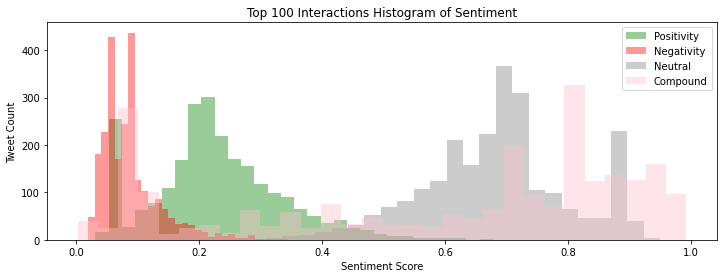

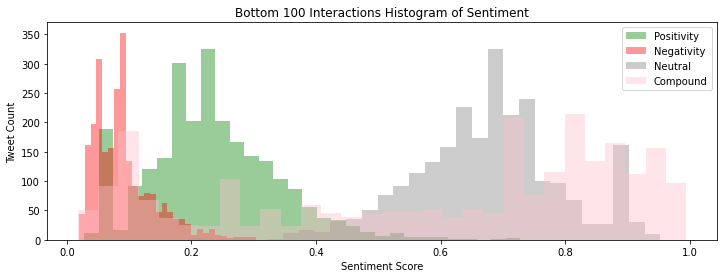

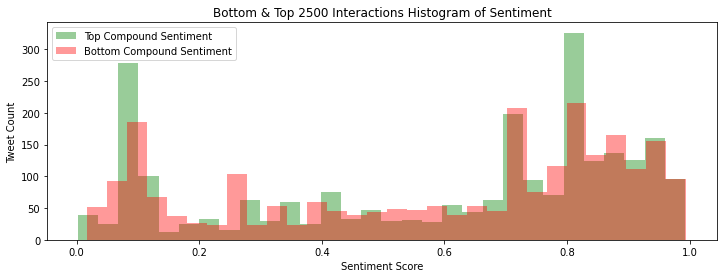

In [24]:
top100 = top100.loc[output['Positivity'] > 0]
top100 = top100.loc[output['Negativity'] > 0]
top100 = top100.loc[output['Neutral'] > 0]
top100 = top100.loc[output['Compound'] > 0]
button100 = button100.loc[output['Positivity'] > 0]
button100 = button100.loc[output['Negativity'] > 0]
button100 = button100.loc[output['Neutral'] > 0]
button100 = button100.loc[output['Compound'] > 0]

plt.figure(figsize=(12,4))
sns.distplot(top100['Positivity'], bins=30, kde=False, 
                color='green', label='Positivity')
sns.distplot(top100['Negativity'], bins=30, kde=False, 
            color='red', label='Negativity')      
sns.distplot(top100['Neutral'], bins=30, kde=False, 
            color='grey', label='Neutral')
sns.distplot(top100['Compound'], bins=30, kde=False, 
            color='pink', label='Compound')
plt.ylabel('Tweet Count')
plt.xlabel('Sentiment Score')
plt.legend()
plt.title(f'Top 100 Interactions Histogram of Sentiment')

button100 = button100.loc[output['Positivity'] > 0]
button100 = button100.loc[output['Negativity'] > 0]
button100 = button100.loc[output['Neutral'] > 0]
button100 = button100.loc[output['Compound'] > 0]

plt.figure(figsize=(12,4))
sns.distplot(button100['Positivity'], bins=30, kde=False, 
                color='green', label='Positivity')
sns.distplot(button100['Negativity'], bins=30, kde=False, 
            color='red', label='Negativity')      
sns.distplot(button100['Neutral'], bins=30, kde=False, 
            color='grey', label='Neutral')
sns.distplot(button100['Compound'], bins=30, kde=False, 
            color='pink', label='Compound')
plt.ylabel('Tweet Count')
plt.xlabel('Sentiment Score')
plt.legend()
plt.title(f'Bottom 100 Interactions Histogram of Sentiment')

plt.figure(figsize=(12,4))
sns.distplot(top100['Compound'], bins=30, kde=False, 
                color='green', label='Top Compound Sentiment')
sns.distplot(button100['Compound'], bins=30, kde=False, 
            color='red', label='Bottom Compound Sentiment')      
plt.ylabel('Tweet Count')
plt.xlabel('Sentiment Score')
plt.legend()
plt.title(f'Bottom & Top 2500 Interactions Histogram of Sentiment')

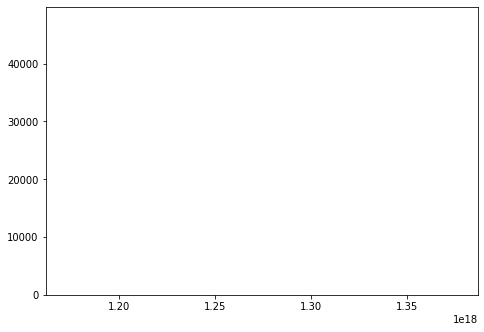

In [20]:
output = output.sort_values(by = 'total', ascending = False)
graph = output.head(2)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(graph['author_id'], graph['total'])
plt.show()